In [1]:
import json
import os
import cv2
import numpy as np

from concurrent.futures import ThreadPoolExecutor, as_completed

from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import tensorflow_models as tfm
import tensorflow_hub as hub
import tensorflow as tf

from sklearn.model_selection import train_test_split

from model import create_vit_lstm_model

gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2024-09-02 17:31:41.305993: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-02 17:31:41.317664: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-02 17:31:41.321029: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Physical devices cannot be modified after being initialized


I0000 00:00:1725278503.608402   12924 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725278503.635114   12924 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725278503.635290   12924 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725278503.637734   12924 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [2]:
# Getting Dataset

def load_frames_from_video(video_dir, img_size=(224, 224)):
    frame_files = sorted([os.path.join(video_dir, img) for img in os.listdir(video_dir) if img.endswith('.jpg') or img.endswith('.png')])
    
    frames = []
    for img_path in frame_files:
        image = tf.image.decode_image(tf.io.read_file(img_path), channels=3)
        image = tf.image.resize(image, img_size)
        frames.append(image)
    
    return tf.stack(frames)

def create_dataset(file_names, labels, base_path, img_size=(224, 224), batch_size=8):
    file_paths = [os.path.join(base_path, file_name.replace('.mp4', '')) for file_name in file_names]

    def load_and_preprocess(video_dir, label):
        frames = load_frames_from_video(video_dir.numpy().decode(), img_size)
        return frames, label
    
    def tf_load_and_preprocess(video_dir, label):
        frames, label = tf.py_function(load_and_preprocess, [video_dir, label], [tf.float32, tf.int32])
        frames.set_shape([None, *img_size, 3])  # Set shape with None for dynamic number of frames
        label.set_shape(())
        return frames, label
    
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(tf_load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.padded_batch(batch_size, padded_shapes=([None, *img_size, 3], []))  # Use padded_batch for dynamic sequences
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [3]:
data_dir = './data/dfdc_train_part_02'
metadata_path = os.path.join(data_dir, 'metadata.json')
frames_dir_train  = os.path.join(data_dir, 'frames')

# Load metadata
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

file_names_train = []
labels_train = []
for key, value in metadata.items():
    file_names_train.append(key)
    labels_train.append(1 if value['label'] == 'FAKE' else 0)


train_dataset = create_dataset(file_names=file_names_train, labels=labels_train, base_path=frames_dir_train, batch_size=2)

In [4]:
data_dir_test = './data/dfdc_train_part_0'
metadata_path_test = os.path.join(data_dir_test, 'metadata.json')
frames_dir_test  = os.path.join(data_dir_test, 'frames')

# Load metadata
with open(metadata_path_test, 'r') as f:
    metadata_test = json.load(f)

file_names_test = []
labels_test = []
for key, value in metadata_test.items():
    file_names_test.append(key)
    labels_test.append(1 if value['label'] == 'FAKE' else 0)

test_dataset = create_dataset(file_names=file_names_test, labels=labels_test, base_path=frames_dir_test)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 224, │          0 │ -                 │
│ (InputLayer)        │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None, 64)  │    382,144 │ input_layer[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, None, 256) │    197,632 │ time_distributed… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, None, 256) │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     32,896 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 128)       │          0 │ dense_8[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 2)         │        258 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 612,930 (2.34 MB)

 Trainable params: 612,930 (2.34 MB)

 Non-trainable params: 0 (0.00 B)

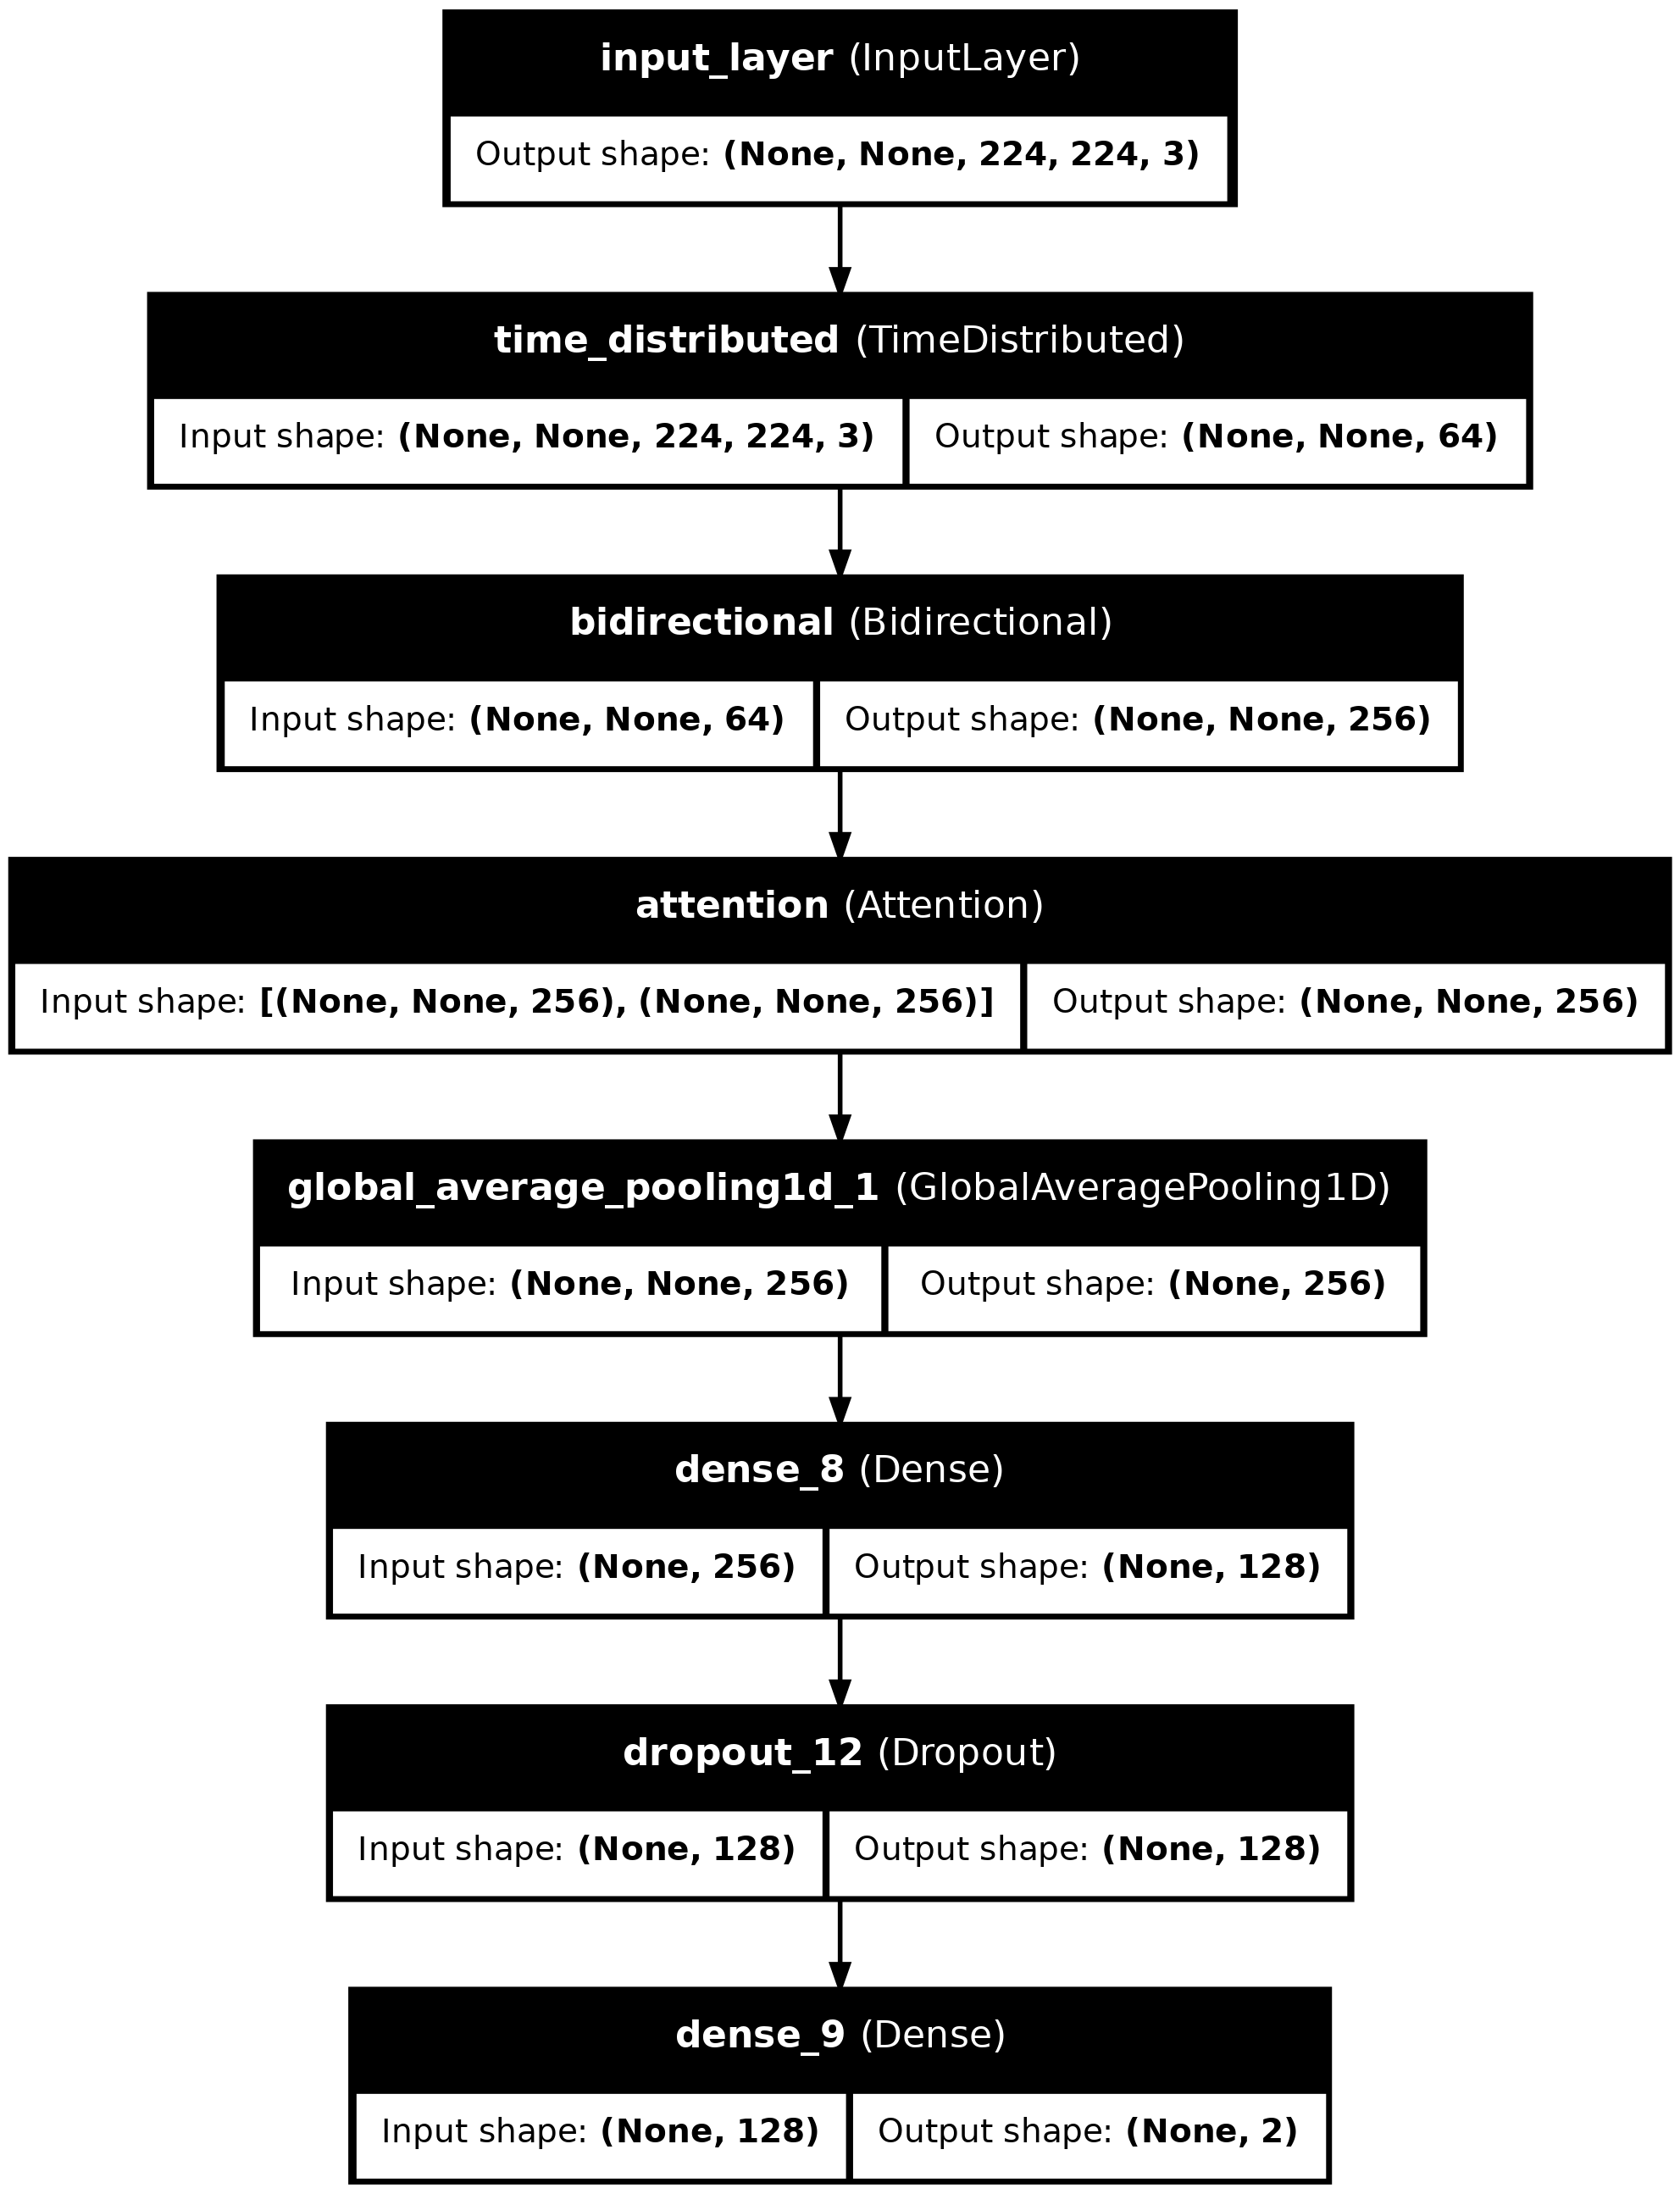

In [5]:
input_shape = (224, 224, 3)
num_classes = 2

model = create_vit_lstm_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [6]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
checkpoint = ModelCheckpoint('testing.keras', monitor='val_loss', save_best_only=True)

callbacks = [early_stopping, reduce_lr, checkpoint]

# Train the model
model.fit(
    train_dataset,
    epochs=20,
    validation_data=test_dataset,
    callbacks=callbacks
)

Epoch 1/20


W0000 00:00:1725278516.614740   13105 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725278516.652139   13105 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725278516.662322   13105 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725278516.664786   13105 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725278516.673358   13105 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725278516.702963   13105 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725278516.714772   13105 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725278516.719824   13105 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725278516.730981   13105 gp

  1/874 ━━━━━━━━━━━━━━━━━━━━ 3:33:33 15s/step - accuracy: 0.5000 - loss: 0.6600

W0000 00:00:1725278519.760909   13108 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725278519.767389   13108 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725278519.770611   13108 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725278519.835799   13108 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725278519.874328   13108 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


 36/874 ━━━━━━━━━━━━━━━━━━━━ 10:14 734ms/step - accuracy: 0.8750 - loss: 0.4279

In [ ]:
model.evaluate(test_dataset)

In [ ]:
model.evaluate(train_dataset)

In [ ]:
video = '/home/blank/projects/deepFakeDetection/training/data/dfdc_train_part_02/acazlolrpz.mp4'
output_dir = './inference_frames'
video_frame_dir = os.path.join(output_dir, os.path.basename(video).replace('.mp4', ''))
print(video_frame_dir)

In [ ]:
from preprocessing import extract_frames_single_video
extract_frames_single_video((video, output_dir, 1))
frame_files = sorted([os.path.join(video_frame_dir, img) for img in os.listdir(video_frame_dir) if img.endswith('.jpg') or img.endswith('.png')])
frames = []
for img_path in frame_files:
    image = tf.image.decode_image(tf.io.read_file(img_path), channels=3)
    image = tf.image.resize(image, (224, 224))
    frames.append(image)
frames = tf.stack(frames)


In [ ]:
frames = tf.expand_dims(frames, axis=0)

In [ ]:
model = tf.keras.models.load_model('testing.keras')

In [ ]:
model.predict(frames)